<h1>Evaluation</h1>
<h2>Notes</h2>

Evaluate Queries based on Class/Distances

Different metrics
1) Truth Table -> How many of class c are returned given query size s. Incooperate distance measure as confidence metric. 
2) Mean Average Precision
3) Last Rank -> Last True Positive
4) ROC-Curve ANN system vs custom system (compare different distance metrics) - AUROC - invariant to query size
5) Confusion Matrix of Class Search -> weighed by inverse distance

Ideas: Measure inter-class distance according to our metric



In [2]:
import pandas as pd
from retrieval import RetrievalEngine
import numpy as np

ret = RetrievalEngine()
df_meta = ret.metadata

custom_dist = np.load("custom_distances.npz")['dist']
ann_dist = np.load("ann_distances.npz")['dist']

In [3]:
custom_dist.shape, ann_dist.shape

((2419, 2419), (2419, 2419))

In [4]:
# argsort by dist for each x
# take top s (or all for auc roc)
# argsort to label (binary for metrics, multilabel for aucroc)
# Group by class (calculate per class)
# Calculate metrics


In [127]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

D = custom_dist.shape[0]

def conf_matrix(query, label, k, c):
    s = k
    y_pred = (query[:s] == label).to_numpy(dtype=int)
    tp = sum(y_pred)
    fp = s - tp
    fn = c - tp
    tn = D - s - fn
    return tn, fp, fn, tp

class_counts = ret.metadata['class'].value_counts()
c_dict = class_counts.to_dict()
conf_matrix(ret.metadata['class'].iloc[custom_dist.argsort()[0]], ret.metadata['class'].iloc[0], k=4, c=c_dict[ret.metadata['class'].iloc[0]])
# .iloc[custom_dist.argsort()[0]]



(np.int64(2402), np.int64(2), np.int64(13), np.int64(2))

In [128]:
# FN + TN = d - s
# tn = d - s - fn

In [178]:
df_dist = pd.DataFrame(custom_dist)
df_dist['class'] = df_meta['class']
df_grouped_dist = df_dist.groupby('class')

In [212]:
def apply_conf_matrix(group, k=8):

    label = group['class'].iloc[0]

    conf_matrices = np.zeros(4, dtype=int)

    for idx_query in group.drop('class', axis=1).to_numpy().argsort():
        query = df_meta.loc[idx_query, 'class']

        conf_matrices += conf_matrix(query, label, k, c_dict[label])

    tn, fp, fn, tp = conf_matrices
    return pd.Series({"tn":tn, "fp":fp, "fn":fn, "tp":tp})
k=10
df_conf_matrix_per_class = df_grouped_dist.apply(apply_conf_matrix, k=k)
df_conf_matrix_per_class

/tmp/ipykernel_4148/1426962747.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_conf_matrix_per_class = df_grouped_dist.apply(apply_conf_matrix, k=k)


,tn,fp,fn,tp
class,,,,
AircraftBuoyant,35934,126,201,24
Apartment,54918,190,489,40
AquaticAnimal,69084,226,777,64
Bed,64408,176,635,94
Bicycle,62143,75,491,185
...,...,...,...,...
TruckNonContainer,38320,128,224,32
Vase,45446,154,325,36
Violin,45451,149,320,41


In [221]:
df_conf_matrix_per_class.loc['All Classes'] = df_conf_matrix_per_class.sum(axis=0)



In [222]:
tn = df_conf_matrix_per_class['tn']
fp = df_conf_matrix_per_class['fp']
fn = df_conf_matrix_per_class['fn']
tp = df_conf_matrix_per_class['tp']
df_conf_matrix_per_class[f'precision@{k}'] = tp / (tp + fp)
df_conf_matrix_per_class[f'recall@{k}'] = tp / (tp + fn)
df_conf_matrix_per_class[f'accuracy@{k}'] = (tp + tn) / (tp + tn + fp + fn)


In [224]:
df_conf_matrix_per_class.loc['All Classes']

tn              5.710264e+06
fp              1.542800e+04
fn              1.171070e+05
tp              8.762000e+03
precision@10    3.622158e-01
recall@10       6.961206e-02
accuracy@10     9.773505e-01
Name: All Classes, dtype: float64

<Axes: ylabel='Count'>

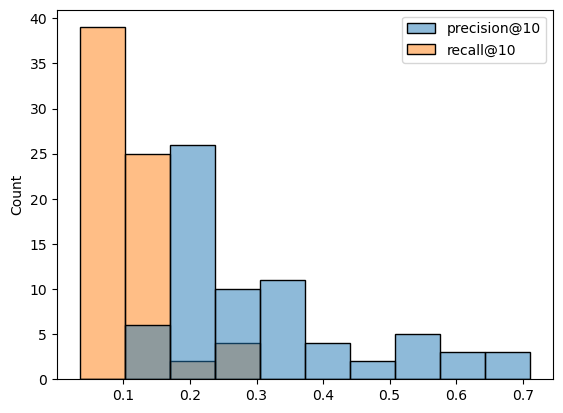

In [223]:
import seaborn as sns
sns.histplot(df_conf_matrix_per_class[[f'precision@{k}', f'recall@{k}']],)
# df_conf_matrix_per_class.plot(y=[f'precision@{k}', f'recall@{k}'], kind='hist')


In [141]:
conf_matrices = np.zeros((D, 4), dtype=int)
k = 8
for i, idx_query in enumerate(ann_dist.argsort()):
    label = ret.metadata.loc[i, 'class']
    query = ret.metadata.loc[idx_query, 'class']
    conf_matrices[i] = conf_matrix(query, label, k, c_dict[label])


In [142]:
tn, fp, fn, tp = conf_matrices.sum(axis=0)
print(f"{tn=}{fp=}{fn=}{tp=}")
{'precision': tp / (tp + fp), 'recall': tp / (tp + fn), 'accuracy': (tp + tn) / (tp + tn + fp + fn), }

tn=np.int64(5713532)fp=np.int64(12160)fn=np.int64(118677)tp=np.int64(7192)


{'precision': np.float64(0.37164117403885905),
 'recall': np.float64(0.057138771262185285),
 'accuracy': np.float64(0.9776406671655649)}

In [140]:
c_dict

{'Jet': 143,
 'Humanoid': 141,
 'Car': 89,
 'Insect': 66,
 'PlantIndoors': 65,
 'RectangleTable': 62,
 'Ship': 61,
 'NonWheelChair': 60,
 'Gun': 58,
 'Quadruped': 56,
 'Sword': 52,
 'Helicopter': 51,
 'HumanHead': 50,
 'Tree': 47,
 'MultiSeat': 45,
 'Door': 44,
 'Biplane': 44,
 'House': 44,
 'Shelf': 43,
 'BuildingNonResidential': 43,
 'Bird': 43,
 'Tool': 42,
 'Chess': 42,
 'Hand': 37,
 'RoundTable': 37,
 'Computer': 32,
 'DeskLamp': 31,
 'Starship': 30,
 'AquaticAnimal': 29,
 'Bottle': 29,
 'Cup': 28,
 'Train': 28,
 'Bed': 27,
 'PlantWildNonTree': 27,
 'Mug': 26,
 'Bicycle': 26,
 'FloorLamp': 26,
 'Motorcycle': 26,
 'Truck': 25,
 'Knife': 24,
 'Apartment': 23,
 'City': 23,
 'Musical_Instrument': 21,
 'WheelChair': 20,
 'Spoon': 20,
 'Guitar': 20,
 'Fish': 20,
 'Cellphone': 20,
 'Monitor': 20,
 'Monoplane': 20,
 'Rocket': 20,
 'MilitaryVehicle': 20,
 'Glasses': 20,
 'Skyscraper': 20,
 'DeskPhone': 19,
 'Violin': 19,
 'Vase': 19,
 'SubmachineGun': 19,
 'Drum': 18,
 'ComputerKeyboard': 